# **Homework #3_P4**

## **Problem 4: Improved UDA model (35%)** 
### **Task Definition**
In this problem, you need to implement an improved model on digits datasets
(USPS, MNIST-M and SVHN) and consider the following 3 scenarios: (Source
domain → Target domain)    
USPS → MNIST-M, MNIST-M → SVHN, SVHN → USPS     
Note that during training your improved UDA model, we utilize the images andlabels of source domain, and only images (without labels) of target domain.
### **Grading**
• If your accuracy of Problem 3-2 does not pass the baseline accuracy,
you only get 3 points in this sub-problem.    
*   Pass the baseline in one scenario: 3+3 points, two: 3+5 points, three: 3+7 points

• Baseline score for DANN:   
*   USPS → MNIST-M: 40% 
*   MNIST-M → SVHN: 40%
*   SVHN → USPS: 40%


• Your accuracy of problem 4-1 should surpass the accuracy reported in
problem 3-2. If not, you only get 6 points in this sub-problem.    
*   Improve in one scenario: 6+4 points, two: 6+7 points, three: 6+10 points

In [ ]:
# connect to drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
path = 'drive/My Drive/senior_1/DLCV/HW/hw3'

Mounted at /content/drive


In [ ]:
!gdown --id '1Cz5eLSP7QRMkO0PqxZLldJ36nK6EWHR8' --output hw3_data.zip # 下載資料集
!unzip hw3_data.zip # 解壓縮
'''
1.  hw3_data/digits/mnistm/
      # num of data: 60,000 (training) / 10,000 (testing) # num of classes: 10 (0~9) # Image size: 28*28*3
      train/images.png
      test/images.png
      train.csv
      test.csv
2.  hw3_data/digits/svhn/
      # num of data: 73,257 (training) / 26,032 (testing) # num of classes: 10 (0~9) # Image size: 28*28*3
      train/images.png
      test/images.png
      train.csv
      test.csv
3.  hw3_data/digits/usps/
      # num of data: 7,291 (training) / 2,007 (testing) # num of classes: 10 (0~9) # Image size: 28*28*1
      train/images.png  
      test/images.png  
      train.csv
      test.csv
'''

In [ ]:
# set packages
!pip3 install certifi==2020.6.20
!pip3 install cycler==0.10.0
!pip3 install joblib==0.17.0
!pip3 install kiwisolver==1.2.0
!pip3 install matplotlib==3.3.2
!pip3 install numpy==1.18.1
!pip3 install pandas==1.1.3
!pip3 install Pillow==8.0.0
!pip3 install pyparsing==2.4.7
!pip3 install python-dateutil==2.8.1
!pip3 install pytz==2020.1
!pip3 install scikit-learn==0.21.3
!pip3 install scipy==1.2.1
!pip3 install six==1.15.0
!pip3 install torch==1.4.0
!pip3 install torchvision==0.5.0

In [ ]:
# Import 需要的套件
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import time
import pandas as pd
import random
import scipy.misc
import argparse
import imageio
from torch.autograd import Variable
from torch.optim import Adam, AdamW
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import manifold
from torch.autograd import Function

# 固定隨機種子
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print("torchvision.__version__ =", torchvision.__version__)
    print("torch.cuda.is_available() =", torch.cuda.is_available())

same_seeds(0)

torchvision.__version__ = 0.5.0
torch.cuda.is_available() = True


#Read image

In [ ]:
def sortfile(path):
    index = []
    image_dir = sorted(os.listdir(path)) # 把圖檔按照編號排列
    for i, file in enumerate(image_dir):
        index.append([file, int(file.replace('.png', ''))])
    index = sorted(index, key = lambda s: s[1])
    return index

def readfile(path, index, mode):
    x = np.zeros((len(index), 28, 28, 3), dtype=np.uint8)
    y = np.zeros((len(index)), dtype=np.uint8)
    pd_y = pd.read_csv(os.path.join(path, mode + ".csv"))
    for i, file in enumerate(index):
        img = imageio.imread(os.path.join(os.path.join(path, mode), file[0]))
        if 'usps' in path:
            temp_x = img.reshape(28, 28, 1) # expand dim
            x[i, :, :] = np.concatenate((temp_x, temp_x, temp_x), axis = 2)
        else:
            x[i, :, :] = img 
        y[i] = pd_y['label'][i] 
    return x, y

In [ ]:
# 分別將 training set、testing set 用 sortfile, readfile 函式讀進來
workspace_dir = './hw3_data/digits'
digits_data_list = ['mnistm', 'svhn', 'usps']

for index in digits_data_list:
    print("Reading " + index + " data")
    split_ratio = 0.2
    train_index = sortfile(os.path.join(workspace_dir, os.path.join(index, "train")))
    test_index = sortfile(os.path.join(workspace_dir, os.path.join(index, "test")))
    if index == 'mnistm':
        mnistm_train_x, mnistm_train_y = readfile(os.path.join(workspace_dir, index), train_index, "train")
        # split train / val, ratio = split_ratio
        mnistm_train_x, mnistm_val_x, mnistm_train_y, mnistm_val_y = train_test_split(mnistm_train_x, mnistm_train_y, test_size = split_ratio, random_state = 3)
        mnistm_test_x, mnistm_test_y = readfile(os.path.join(workspace_dir, index), test_index, "test")
        mnistm_test_index = pd.DataFrame(test_index)[0].values.tolist()
    elif index == 'svhn':
        svhn_train_x, svhn_train_y = readfile(os.path.join(workspace_dir, index), train_index, "train")
        # split train / val, ratio = split_ratio
        svhn_train_x, svhn_val_x, svhn_train_y, svhn_val_y = train_test_split(svhn_train_x, svhn_train_y, test_size = split_ratio, random_state = 3) 
        svhn_test_x, svhn_test_y = readfile(os.path.join(workspace_dir, index), test_index, "test")
        svhn_test_index = pd.DataFrame(test_index)[0].values.tolist()  
    else:
        usps_train_x, usps_train_y = readfile(os.path.join(workspace_dir, index), train_index, "train")
        # split train / val, ratio = split_ratio
        usps_train_x,usps_val_x, usps_train_y, usps_val_y = train_test_split(usps_train_x, usps_train_y, test_size = split_ratio, random_state = 3)
        usps_test_x, usps_test_y = readfile(os.path.join(workspace_dir, index), test_index, "test") 
        usps_test_index = pd.DataFrame(test_index)[0].values.tolist()
    print("Size of {} training data = {}".format(index, round(len(train_index)*(1-split_ratio))))
    print("Size of {} validation data = {}".format(index, round(len(train_index)*split_ratio)))
    print("Size of {} testing data = {}".format(index, round(len(test_index))))

Reading mnistm data
Size of mnistm training data = 48000
Size of mnistm validation data = 12000
Size of mnistm testing data = 10000
Reading svhn data
Size of svhn training data = 58606
Size of svhn validation data = 14651
Size of svhn testing data = 26032
Reading usps data
Size of usps training data = 5833
Size of usps validation data = 1458
Size of usps testing data = 2007


# Dataset
在 PyTorch 中，我們可以利用 torch.utils.data 的 Dataset 及 DataLoader 來"包裝" data，使後續的 training 及 testing 更為方便。

Dataset 需要 overload 兩個函數：\_\_len\_\_ 及 \_\_getitem\_\_

\_\_len\_\_ 必須要回傳 dataset 的大小，而 \_\_getitem\_\_ 則定義了當程式利用 [ ] 取值時，dataset 應該要怎麼回傳資料。

實際上我們並不會直接使用到這兩個函數，但是使用 DataLoader 在 enumerate Dataset 時會使用到，沒有實做的話會在程式運行階段出現 error。


In [ ]:
# training 時需做 data augmentation
train_transform = transforms.Compose([
    transforms.ToPILImage(), # 轉成 python 圖片
    transforms.ToTensor(), # 將圖片轉成 Tensor，並把數值 normalize 到 [0,1] (data normalization) ps. Tensor 為多維張量
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) # normalize
])

# testing 時不需做 data augmentation
test_transform = transforms.Compose([
    transforms.ToPILImage(),                                    
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) # normalize
])

class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None): # transform 自己決定
        self.x = x
        # label is required to be a LongTensor
        self.y = y
        if y is not None:
            self.y = torch.LongTensor(y)
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X

In [ ]:
batch_size = 64
train_x_list = [mnistm_train_x, svhn_train_x, usps_train_x]
val_x_list = [mnistm_val_x, svhn_val_x, usps_val_x]
test_x_list = [mnistm_test_x, svhn_test_x, usps_test_x]
train_y_list = [mnistm_train_y, svhn_train_y, usps_train_y]
val_y_list = [mnistm_val_y, svhn_val_y, usps_val_y]
test_y_list = [mnistm_test_y, svhn_test_y, usps_test_y]
for i in range(len(train_x_list)):
    train_set = ImgDataset(train_x_list[i], train_y_list[i], transform=train_transform)
    val_set = ImgDataset(val_x_list[i], val_y_list[i], transform=test_transform)
    test_set = ImgDataset(test_x_list[i], test_y_list[i], transform=test_transform)
    if i == 0: # mnistm
        mnistm_train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
        mnistm_val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
        mnistm_test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
        print('finish mnistm_loader')
    elif i == 1: # svhn
        svhn_train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
        svhn_val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
        svhn_test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
        print('finish svhn_loader')
    else: # usps
        usps_train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
        usps_val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
        usps_test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
        print('finish usps_loader')

finish mnistm_loader
finish svhn_loader
finish usps_loader


## USPS → MNIST-M DSN model

In [ ]:
class DSN_PSE_USPS2MNISTM(nn.Module):
    # private source encoder
    def __init__(self, code_size=100):
        super(DSN_PSE_USPS2MNISTM, self).__init__()
        self.code_size = code_size
        self.source_encoder_conv = nn.Sequential(
            # input_size = (28, 28, 3)
            # output_size = (input_size-kernel_size+2*padding)/stride + 1
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3)), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # [batch_size, 64, 32, 32]

            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # [batch_size, 128, 32, 32]

            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
             # [batch_size, 256, 16, 16]

            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 8, 8]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 4, 4]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 2, 2]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 1, 1]
        )
        self.source_encoder_fc = nn.Sequential(
            nn.Linear(in_features=1*1*512, out_features=code_size),
            nn.BatchNorm1d(code_size),
            nn.ReLU(),
            # [batch_size, code_size]
        )

    def forward(self, input_data):
        private_feat = self.source_encoder_conv(input_data)
        private_feat = private_feat.view(-1, 512*1*1)
        private_code = self.source_encoder_fc(private_feat)
        return private_code


class DSN_PTE_USPS2MNISTM(nn.Module):
    # private target encoder
    def __init__(self, code_size=100):
        super(DSN_PTE_USPS2MNISTM, self).__init__()
        self.code_size = code_size
        self.target_encoder_conv = nn.Sequential(
            # input_size = (28, 28, 3)
            # output_size = (input_size-kernel_size+2*padding)/stride + 1
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3)), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # [batch_size, 64, 32, 32]

            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # [batch_size, 128, 32, 32]

            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
             # [batch_size, 256, 16, 16]

            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 8, 8]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 4, 4]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 2, 2]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 1, 1]
        )
        self.target_encoder_fc = nn.Sequential(
            nn.Linear(in_features=1*1*512, out_features=code_size),
            nn.BatchNorm1d(code_size),
            nn.ReLU(),
            # [batch_size, code_size]
        )

    def forward(self, input_data):
        private_feat = self.target_encoder_conv(input_data)
        private_feat = private_feat.view(-1, 512*1*1)
        private_code = self.target_encoder_fc(private_feat)
        return private_code


class DSN_SE_USPS2MNISTM(nn.Module):
    # private shared encoder
    def __init__(self, code_size=100):
        super(DSN_SE_USPS2MNISTM, self).__init__()
        self.shared_encoder_conv = nn.Sequential(
            # input_size = (28, 28, 3)
            # output_size = (input_size-kernel_size+2*padding)/stride + 1
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3)), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # [batch_size, 64, 32, 32]

            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # [batch_size, 128, 32, 32]

            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
             # [batch_size, 256, 16, 16]

            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 8, 8]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 4, 4]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 2, 2]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 1, 1]
        )
        self.shared_encoder_fc = nn.Sequential(
            nn.Linear(in_features=1*1*512, out_features=code_size),
            nn.BatchNorm1d(code_size),
            nn.ReLU(),
            # [batch_size, code_size]
        )

    def forward(self, input_data):
        # shared encoder
        shared_feat = self.shared_encoder_conv(input_data)
        shared_feat = shared_feat.view(-1, 512*1*1)
        shared_code = self.shared_encoder_fc(shared_feat)
        return shared_code

class DSN_CC_USPS2MNISTM(nn.Module):
    # classify 10 numbers
    def __init__(self, code_size=512, n_class=10):
        super(DSN_CC_USPS2MNISTM, self).__init__()
        self.shared_encoder_pred_class = nn.Sequential(
            nn.Linear(code_size, 512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, n_class),
            # [batch_size, 10]
        )

    def forward(self, shared_code):
        # shared encoder
        class_label = self.shared_encoder_pred_class(shared_code)
        return class_label

class DSN_DC_USPS2MNISTM(nn.Module):
    # classify two domain
    def __init__(self, code_size=512, n_class=10):
        super(DSN_DC_USPS2MNISTM, self).__init__()
        self.shared_encoder_pred_domain = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1),
            # [batch_size, 1]
        )

    def forward(self, shared_code):
        # shared encoder
        domain_label = self.shared_encoder_pred_domain(shared_code)
        return domain_label


class DSN_SD_USPS2MNISTM(nn.Module):
    # shared decoder
    def __init__(self, code_size=512):
        super(DSN_SD_USPS2MNISTM, self).__init__()

        self.shared_decoder_fc = nn.Sequential(
            nn.Linear(in_features=code_size, out_features=588),
            nn.BatchNorm1d(588),
            nn.ReLU(),
            # [batch_size, 588]
        )
        self.shared_decoder_conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # [batch_size, 16, 14, 14]

            nn.Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # [batch_size, 16, 14, 14] 

            nn.Upsample(scale_factor=2),
            # [batch_size, 16, 28, 28] 

            nn.Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # [batch_size, 16, 28, 28] 

            nn.Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            # [batch_size, 3, 28, 28]                   
        )

    def forward(self, union_code):
        rec_vec = self.shared_decoder_fc(union_code)
        rec_vec = rec_vec.view(-1, 3, 14, 14)
        rec_code = self.shared_decoder_conv(rec_vec)
        return rec_code

## MNIST-M → SVHN DSN model

In [ ]:
class DSN_PSE_MNISTM2SVHN(nn.Module):
    # private source encoder
    def __init__(self, code_size=100):
        super(DSN_PSE_MNISTM2SVHN, self).__init__()
        self.code_size = code_size
        self.source_encoder_conv = nn.Sequential(
            # input_size = (28, 28, 3)
            # output_size = (input_size-kernel_size+2*padding)/stride + 1
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3)), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # [batch_size, 64, 32, 32]

            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # [batch_size, 128, 32, 32]

            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
             # [batch_size, 256, 16, 16]

            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 8, 8]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 4, 4]
        )
        self.source_encoder_fc = nn.Sequential(
            nn.Linear(in_features=4*4*512, out_features=code_size),
            nn.BatchNorm1d(code_size),
            nn.ReLU(),
            # [batch_size, code_size]
        )

    def forward(self, input_data):
        private_feat = self.source_encoder_conv(input_data)
        private_feat = private_feat.view(-1, 512*4*4)
        private_code = self.source_encoder_fc(private_feat)
        return private_code


class DSN_PTE_MNISTM2SVHN(nn.Module):
    # private target encoder
    def __init__(self, code_size=100):
        super(DSN_PTE_MNISTM2SVHN, self).__init__()
        self.code_size = code_size
        self.target_encoder_conv = nn.Sequential(
            # input_size = (28, 28, 3)
            # output_size = (input_size-kernel_size+2*padding)/stride + 1
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3)), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # [batch_size, 64, 32, 32]

            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # [batch_size, 128, 32, 32]

            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
             # [batch_size, 256, 16, 16]

            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 8, 8]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 4, 4]
        )
        self.target_encoder_fc = nn.Sequential(
            nn.Linear(in_features=4*4*512, out_features=code_size),
            nn.BatchNorm1d(code_size),
            nn.ReLU(),
            # [batch_size, code_size]
        )

    def forward(self, input_data):
        private_feat = self.target_encoder_conv(input_data)
        private_feat = private_feat.view(-1, 512*4*4)
        private_code = self.target_encoder_fc(private_feat)
        return private_code


class DSN_SE_MNISTM2SVHN(nn.Module):
    # private shared encoder
    def __init__(self, code_size=100):
        super(DSN_SE_MNISTM2SVHN, self).__init__()
        self.shared_encoder_conv = nn.Sequential(
            # input_size = (28, 28, 3)
            # output_size = (input_size-kernel_size+2*padding)/stride + 1
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3)), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # [batch_size, 64, 32, 32]

            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # [batch_size, 128, 32, 32]

            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
             # [batch_size, 256, 16, 16]

            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 8, 8]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 4, 4]
        )
        self.shared_encoder_fc = nn.Sequential(
            nn.Linear(in_features=4*4*512, out_features=code_size),
            nn.BatchNorm1d(code_size),
            nn.ReLU(),
            # [batch_size, code_size]
        )

    def forward(self, input_data):
        # shared encoder
        shared_feat = self.shared_encoder_conv(input_data)
        shared_feat = shared_feat.view(-1, 512*4*4)
        shared_code = self.shared_encoder_fc(shared_feat)
        return shared_code

class DSN_CC_MNISTM2SVHN(nn.Module):
    # classify 10 numbers
    def __init__(self, code_size=512, n_class=10):
        super(DSN_CC_MNISTM2SVHN, self).__init__()
        self.shared_encoder_pred_class = nn.Sequential(
            nn.Linear(code_size, 512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, n_class),
            # [batch_size, 10]
        )

    def forward(self, shared_code):
        # shared encoder
        class_label = self.shared_encoder_pred_class(shared_code)
        return class_label

class DSN_DC_MNISTM2SVHN(nn.Module):
    # classify two domain
    def __init__(self, code_size=512, n_class=10):
        super(DSN_DC_MNISTM2SVHN, self).__init__()
        self.shared_encoder_pred_domain = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1),
            # [batch_size, 1]
        )

    def forward(self, shared_code):
        # shared encoder
        domain_label = self.shared_encoder_pred_domain(shared_code)
        return domain_label


class DSN_SD_MNISTM2SVHN(nn.Module):
    # shared decoder
    def __init__(self, code_size=512):
        super(DSN_SD_MNISTM2SVHN, self).__init__()

        self.shared_decoder_fc = nn.Sequential(
            nn.Linear(in_features=code_size, out_features=588),
            nn.BatchNorm1d(588),
            nn.ReLU(),
            # [batch_size, 588]
        )
        self.shared_decoder_conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # [batch_size, 16, 14, 14]

            nn.Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # [batch_size, 16, 14, 14] 

            nn.Upsample(scale_factor=2),
            # [batch_size, 16, 28, 28] 

            nn.Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # [batch_size, 16, 28, 28] 

            nn.Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            # [batch_size, 3, 28, 28]                   
        )

    def forward(self, union_code):
        rec_vec = self.shared_decoder_fc(union_code)
        rec_vec = rec_vec.view(-1, 3, 14, 14)
        rec_code = self.shared_decoder_conv(rec_vec)
        return rec_code

## SVHN → USPS DSN model

In [ ]:
class DSN_PSE_SVHN2USPS(nn.Module):
    # private source encoder
    def __init__(self, code_size=100):
        super(DSN_PSE_SVHN2USPS, self).__init__()
        self.code_size = code_size
        self.source_encoder_conv = nn.Sequential(
            # input_size = (28, 28, 3)
            # output_size = (input_size-kernel_size+2*padding)/stride + 1
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3)), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # [batch_size, 64, 32, 32]

            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # [batch_size, 128, 32, 32]

            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
             # [batch_size, 256, 16, 16]

            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 8, 8]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 4, 4]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 2, 2]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 1, 1]
        )
        self.source_encoder_fc = nn.Sequential(
            nn.Linear(in_features=1*1*512, out_features=code_size),
            nn.BatchNorm1d(code_size),
            nn.ReLU(),
            # [batch_size, code_size]
        )

    def forward(self, input_data):
        private_feat = self.source_encoder_conv(input_data)
        private_feat = private_feat.view(-1, 512*1*1)
        private_code = self.source_encoder_fc(private_feat)
        return private_code


class DSN_PTE_SVHN2USPS(nn.Module):
    # private target encoder
    def __init__(self, code_size=100):
        super(DSN_PTE_SVHN2USPS, self).__init__()
        self.code_size = code_size
        self.target_encoder_conv = nn.Sequential(
            # input_size = (28, 28, 3)
            # output_size = (input_size-kernel_size+2*padding)/stride + 1
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3)), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # [batch_size, 64, 32, 32]

            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # [batch_size, 128, 32, 32]

            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
             # [batch_size, 256, 16, 16]

            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 8, 8]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 4, 4]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 2, 2]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 1, 1]
        )
        self.target_encoder_fc = nn.Sequential(
            nn.Linear(in_features=1*1*512, out_features=code_size),
            nn.BatchNorm1d(code_size),
            nn.ReLU(),
            # [batch_size, code_size]
        )

    def forward(self, input_data):
        private_feat = self.target_encoder_conv(input_data)
        private_feat = private_feat.view(-1, 512*1*1)
        private_code = self.target_encoder_fc(private_feat)
        return private_code


class DSN_SE_SVHN2USPS(nn.Module):
    # private shared encoder
    def __init__(self, code_size=100):
        super(DSN_SE_SVHN2USPS, self).__init__()
        self.shared_encoder_conv = nn.Sequential(
            # input_size = (28, 28, 3)
            # output_size = (input_size-kernel_size+2*padding)/stride + 1
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3)), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # [batch_size, 64, 32, 32]

            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # [batch_size, 128, 32, 32]

            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
             # [batch_size, 256, 16, 16]

            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 8, 8]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 4, 4]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 2, 2]

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, 512, 1, 1]
        )
        self.shared_encoder_fc = nn.Sequential(
            nn.Linear(in_features=1*1*512, out_features=code_size),
            nn.BatchNorm1d(code_size),
            nn.ReLU(),
            # [batch_size, code_size]
        )

    def forward(self, input_data):
        # shared encoder
        shared_feat = self.shared_encoder_conv(input_data)
        shared_feat = shared_feat.view(-1, 512*1*1)
        shared_code = self.shared_encoder_fc(shared_feat)
        return shared_code

class DSN_CC_SVHN2USPS(nn.Module):
    # classify 10 numbers
    def __init__(self, code_size=512, n_class=10):
        super(DSN_CC_SVHN2USPS, self).__init__()
        self.shared_encoder_pred_class = nn.Sequential(
            nn.Linear(code_size, 512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, n_class),
            # [batch_size, 10]
        )

    def forward(self, shared_code):
        # shared encoder
        class_label = self.shared_encoder_pred_class(shared_code)
        return class_label

class DSN_DC_SVHN2USPS(nn.Module):
    # classify two domain
    def __init__(self, code_size=512, n_class=10):
        super(DSN_DC_SVHN2USPS, self).__init__()
        self.shared_encoder_pred_domain = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1),
            # [batch_size, 1]
        )

    def forward(self, shared_code):
        # shared encoder
        domain_label = self.shared_encoder_pred_domain(shared_code)
        return domain_label


class DSN_SD_SVHN2USPS(nn.Module):
    # shared decoder
    def __init__(self, code_size=512):
        super(DSN_SD_SVHN2USPS, self).__init__()

        self.shared_decoder_fc = nn.Sequential(
            nn.Linear(in_features=code_size, out_features=588),
            nn.BatchNorm1d(588),
            nn.ReLU(),
            # [batch_size, 588]
        )
        self.shared_decoder_conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # [batch_size, 16, 14, 14]

            nn.Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # [batch_size, 16, 14, 14] 

            nn.Upsample(scale_factor=2),
            # [batch_size, 16, 28, 28] 

            nn.Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # [batch_size, 16, 28, 28] 

            nn.Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            # [batch_size, 3, 28, 28]                   
        )

    def forward(self, union_code):
        rec_vec = self.shared_decoder_fc(union_code)
        rec_vec = rec_vec.view(-1, 3, 14, 14)
        rec_code = self.shared_decoder_conv(rec_vec)
        return rec_code

## testing

In [ ]:
def set_model(target_domain_name):
    if target_domain_name == 'mnistm':
        DSN_PSE_model_temp = DSN_PSE_USPS2MNISTM(512).cuda()   # private source encoder
        DSN_PTE_model_temp = DSN_PTE_USPS2MNISTM(512).cuda()   # private target encoder
        DSN_SE_model_temp = DSN_SE_USPS2MNISTM(512).cuda()     # share encoder
        DSN_CC_model_temp = DSN_CC_USPS2MNISTM(512, 10).cuda() # class classifier
        DSN_DC_model_temp = DSN_DC_USPS2MNISTM(512, 1).cuda()  # doamin classifier
        DSN_SD_model_temp = DSN_SD_USPS2MNISTM(512).cuda()     # share decoder 
    elif target_domain_name == 'svhn':
        DSN_PSE_model_temp = DSN_PSE_MNISTM2SVHN(512).cuda()   # private source encoder
        DSN_PTE_model_temp = DSN_PTE_MNISTM2SVHN(512).cuda()   # private target encoder
        DSN_SE_model_temp = DSN_SE_MNISTM2SVHN(512).cuda()     # share encoder
        DSN_CC_model_temp = DSN_CC_MNISTM2SVHN(512, 10).cuda() # class classifier
        DSN_DC_model_temp = DSN_DC_MNISTM2SVHN(512, 1).cuda()  # doamin classifier
        DSN_SD_model_temp = DSN_SD_MNISTM2SVHN(512).cuda()     # share decoder 
    else:
        DSN_PSE_model_temp = DSN_PSE_SVHN2USPS(512).cuda()   # private source encoder
        DSN_PTE_model_temp = DSN_PTE_SVHN2USPS(512).cuda()   # private target encoder
        DSN_SE_model_temp = DSN_SE_SVHN2USPS(512).cuda()     # share encoder
        DSN_CC_model_temp = DSN_CC_SVHN2USPS(512, 10).cuda() # class classifier
        DSN_DC_model_temp = DSN_DC_SVHN2USPS(512, 1).cuda()  # doamin classifier
        DSN_SD_model_temp = DSN_SD_SVHN2USPS(512).cuda()     # share decoder 
    
    return DSN_PSE_model_temp, DSN_PTE_model_temp, DSN_SE_model_temp, DSN_CC_model_temp, DSN_DC_model_temp, DSN_SD_model_temp

def set_loader(target_domain_name):
    if target_domain_name == 'mnistm':
        source_train_loader_temp = usps_train_loader
        target_train_loader_temp = mnistm_train_loader
        target_val_loader_temp = mnistm_val_loader
    elif target_domain_name == 'svhn':
        source_train_loader_temp = mnistm_train_loader
        target_train_loader_temp = svhn_train_loader
        target_val_loader_temp = svhn_val_loader
    else:
        source_train_loader_temp = svhn_train_loader
        target_train_loader_temp = usps_train_loader
        target_val_loader_temp = usps_val_loader

    return source_train_loader_temp, target_train_loader_temp, target_val_loader_temp

In [ ]:
def prediction_output(target_domain_loader, target_domain_name, output_path):
    if target_domain_name == 'mnistm':
        DSN_SE_model = DSN_SE_USPS2MNISTM(512).cuda()     # share encoder
        DSN_CC_model = DSN_CC_USPS2MNISTM(512, 10).cuda() # class classifier
        DSN_SE_model.load_state_dict(torch.load(os.path.join(path, 'p4_USPS2MNISTM_DSN_SE_model.pkl')))
        DSN_CC_model.load_state_dict(torch.load(os.path.join(path, 'p4_USPS2MNISTM_DSN_CC_model.pkl')))
        test_index = mnistm_test_index
    elif target_domain_name == 'svhn':
        DSN_SE_model = DSN_SE_MNISTM2SVHN(512).cuda()     # share encoder
        DSN_CC_model = DSN_CC_MNISTM2SVHN(512, 10).cuda() # class classifier
        DSN_SE_model.load_state_dict(torch.load(os.path.join(path, 'p4_MNISTM2SVHN_DSN_SE_model.pkl')))
        DSN_CC_model.load_state_dict(torch.load(os.path.join(path, 'p4_MNISTM2SVHN_DSN_CC_model.pkl')))
        test_index = svhn_test_index
    else: # target_domain_name == 'usps'
        DSN_SE_model = DSN_SE_SVHN2USPS(512).cuda()     # share encoder
        DSN_CC_model = DSN_CC_SVHN2USPS(512, 10).cuda() # class classifier
        DSN_SE_model.load_state_dict(torch.load(os.path.join(path, 'p4_SVHN2USPS_DSN_SE_model.pkl')))
        DSN_CC_model.load_state_dict(torch.load(os.path.join(path, 'p4_SVHN2USPS_DSN_CC_model.pkl')))
        test_index = usps_test_index

    target_test_acc = 0.0
    target_test_num = 0.0
    initial = True
    DSN_SE_model.eval()
    DSN_CC_model.eval()

    with torch.no_grad():
        for i, (target_test_data, target_test_label) in enumerate(target_domain_loader):
            # Step 4 : test Domain Classifier on testing data
            target_test_data = target_test_data.cuda()
            target_test_label = target_test_label.cuda()
            feature = DSN_SE_model(target_test_data)
            class_logits = DSN_CC_model(feature)
            if initial == True:
                prediction = torch.argmax(class_logits, dim=1).data.cpu().numpy()
                initial = False
            else:
                prediction = np.concatenate((prediction, torch.argmax(class_logits, dim=1).data.cpu().numpy()), axis=0)
            target_test_acc += torch.sum(torch.argmax(class_logits, dim=1) == target_test_label).item()
            target_test_num += target_test_data.shape[0]
    print(target_domain_name + ' target test acc: {:.4f}'.format(target_test_acc/target_test_num))

    # Generate prediction submission
    prediction_name = output_path
    df = pd.DataFrame({'image_name': test_index, 'label': prediction})
    df.to_csv(prediction_name, index=False)
    return df

In [ ]:
df_mnistm = prediction_output(mnistm_test_loader, 'mnistm', 'test_pred_mnistm.csv')
df_svhn = prediction_output(svhn_test_loader, 'svhn', 'test_pred_svhn.csv')
df_usps = prediction_output(usps_test_loader, 'usps', 'test_pred_usps.csv')

# from google.colab import files
# files.download('test_pred.csv')

mnistm target test acc: 0.6949
svhn target test acc: 0.4896
usps target test acc: 0.7255


#Report (35%)

1. Compute the accuracy on target domain, while the model is trained on
source and target domain. (domain adaptation) (6+10%)   
• Use source images and labels + target images for training    
    **You should implement UDA methods other than DANN for your improved UDA model. Some methods are provided at the end of Problem 4 description (page 14).**

In [ ]:
# set model
for task in ['mnistm', 'svhn', 'usps']:
    DSN_PSE_model, DSN_PTE_model, DSN_SE_model, DSN_CC_model, DSN_DC_model, DSN_SD_model = set_model(task)
    print('------------------------------------------------', task, '------------------------------------------------')
    print(DSN_PSE_model)
    print(DSN_PTE_model)
    print(DSN_SE_model)
    print(DSN_CC_model)
    print(DSN_DC_model)
    print(DSN_SD_model)

2. Visualize the the latent space by mapping the testing images to 2D space
(with t-SNE) and use different colors to indicate data of (a) different
digits classes 0-9 and (b) different domains (source/target). (6%)    
• Note that you need to plot the figures of all the three scenarios, so you would need to plot 6 figures in total in this sub-problem.

In [ ]:
# visialize the latent space
def visialize_latent(target_mode):
    if target_mode == 'mnistm':
        DSN_SE_model = DSN_SE_USPS2MNISTM(512).cuda()
        DSN_SE_model.load_state_dict(torch.load(os.path.join(path, 'p4_USPS2MNISTM_DSN_SE_model.pkl')))
        source_test_loader = usps_test_loader
        target_test_loader = mnistm_test_loader
    elif target_mode == 'svhn':
        DSN_SE_model = DSN_SE_MNISTM2SVHN(512).cuda()
        DSN_SE_model.load_state_dict(torch.load(os.path.join(path, 'p4_MNISTM2SVHN_DSN_SE_model.pkl')))
        source_test_loader = mnistm_test_loader
        target_test_loader = svhn_test_loader
    else: # usps
        DSN_SE_model = DSN_SE_SVHN2USPS(512).cuda()
        DSN_SE_model.load_state_dict(torch.load(os.path.join(path, 'p4_SVHN2USPS_DSN_SE_model.pkl')))
        source_test_loader = svhn_test_loader
        target_test_loader = usps_test_loader
    DSN_SE_model.eval()
    feature_source = torch.tensor([]).cuda()
    feature_target = torch.tensor([]).cuda()
    with torch.no_grad():
        for i, (source_test_data, _) in enumerate(source_test_loader):
            source_test_data = source_test_data.cuda()
            feature = DSN_SE_model(source_test_data)
            feature_source = torch.cat((feature_source, feature), 0)
        feature_source = feature_source.data.cpu().numpy()

        for i, (target_test_data, _) in enumerate(target_test_loader):
            target_test_data = target_test_data.cuda()
            feature = DSN_SE_model(target_test_data)
            feature_target = torch.cat((feature_target, feature), 0)
        feature_target = feature_target.data.cpu().numpy()

        return feature_source, feature_target

target_mode_list = ['mnistm', 'svhn', 'usps']
for target_mode in target_mode_list:
    if target_mode == 'mnistm':
        feature_USPS2MNISTM_source, feature_USPS2MNISTM_target = visialize_latent(target_mode)
        feature_USPS2MNISTM = np.concatenate((feature_USPS2MNISTM_source, feature_USPS2MNISTM_target), axis=0)
        class_USPS2MNISTM = np.concatenate((usps_test_y, mnistm_test_y), axis=0)
        domain_USPS2MNISTM = np.concatenate((np.zeros((len(usps_test_y),), dtype=np.int), np.ones((len(mnistm_test_y),), dtype=np.int)), axis=0)
    elif target_mode == 'svhn':
        feature_MNISTM2SVHN_source, feature_MNISTM2SVHN_target = visialize_latent(target_mode)
        feature_MNISTM2SVHN = np.concatenate((feature_MNISTM2SVHN_source, feature_MNISTM2SVHN_target), axis=0)
        class_MNISTM2SVHN = np.concatenate((mnistm_test_y, svhn_test_y), axis=0)
        domain_MNISTM2SVHN = np.concatenate((np.zeros((len(mnistm_test_y),), dtype=np.int), np.ones((len(svhn_test_y),), dtype=np.int)), axis=0)
    else:
        feature_SVHN2USPS_source, feature_SVHN2USPS_target = visialize_latent(target_mode)
        feature_SVHN2USPS = np.concatenate((feature_SVHN2USPS_source, feature_SVHN2USPS_target), axis=0)
        class_SVHN2USPS = np.concatenate((svhn_test_y, usps_test_y), axis=0)
        domain_SVHN2USPS = np.concatenate((np.zeros((len(svhn_test_y),), dtype=np.int), np.ones((len(usps_test_y),), dtype=np.int)), axis=0)
    print('finish ' + target_mode + ' latent')

finish mnistm latent
finish svhn latent
finish usps latent


In [ ]:
# tsne
feature_USPS2MNISTM_embedded = manifold.TSNE(n_components=2, perplexity=30.0, random_state=0, n_iter=250).fit_transform(feature_USPS2MNISTM)
print('finish feature_USPS2MNISTM_embedded')
feature_MNISTM2SVHN_embedded = manifold.TSNE(n_components=2, perplexity=30.0, random_state=0, n_iter=250).fit_transform(feature_MNISTM2SVHN)
print('finish feature_MNISTM2SVHN_embedded')
feature_SVHN2USPS_embedded = manifold.TSNE(n_components=2, perplexity=30.0, random_state=0, n_iter=250).fit_transform(feature_SVHN2USPS)
print('finish feature_SVHN2USPS_embedded')

finish feature_USPS2MNISTM_embedded
finish feature_MNISTM2SVHN_embedded
finish feature_SVHN2USPS_embedded


In [73]:
np.save(os.path.join(path, 'p4_feature_USPS2MNISTM_embedded.npy'), feature_USPS2MNISTM_embedded)
np.save(os.path.join(path, 'p4_feature_MNISTM2SVHN_embedded.npy'), feature_MNISTM2SVHN_embedded)
np.save(os.path.join(path, 'p4_feature_SVHN2USPS_embedded.npy'), feature_SVHN2USPS_embedded)
feature_USPS2MNISTM_embedded = np.load(os.path.join(path, 'p4_feature_USPS2MNISTM_embedded.npy'))
feature_MNISTM2SVHN_embedded = np.load(os.path.join(path, 'p4_feature_MNISTM2SVHN_embedded.npy'))
feature_SVHN2USPS_embedded = np.load(os.path.join(path, 'p4_feature_SVHN2USPS_embedded.npy'))

ok
ok
ok
ok
ok
ok
save tsne image


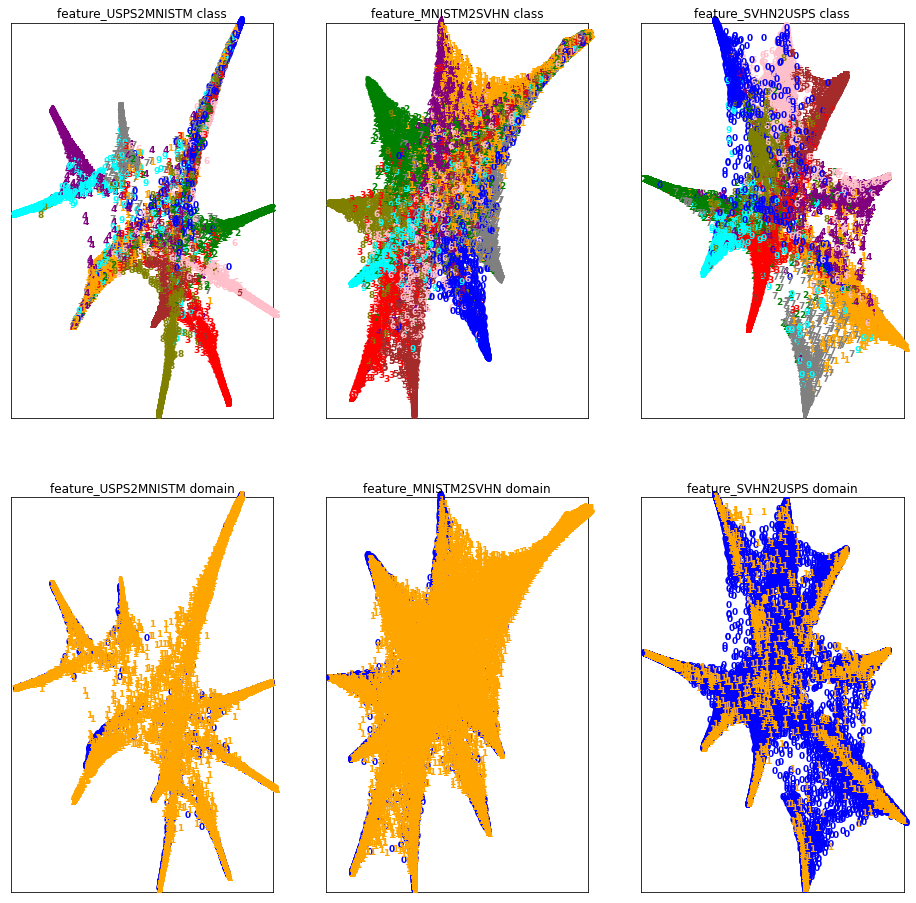

In [ ]:
plt.figure(figsize=(16, 16))
color_map = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

for i in range(6):
    plt.subplot(2, 3, i+1)
    if i%3 == 0: # USPS2MNISTM
        X_tsne = feature_USPS2MNISTM_embedded
        if i == 0: # num
            y = class_USPS2MNISTM
            plt.title('feature_USPS2MNISTM class')
        else: # domain
            y = domain_USPS2MNISTM
            plt.title('feature_USPS2MNISTM domain')

    elif i%3 == 1: # USPS2MNISTM
        X_tsne = feature_MNISTM2SVHN_embedded
        if i == 1: # num
            y = class_MNISTM2SVHN
            plt.title('feature_MNISTM2SVHN class')
        else: # domain
            y = domain_MNISTM2SVHN
            plt.title('feature_MNISTM2SVHN domain')
    else: # i == 2 or i == 5 SVHN2USPS     
        X_tsne = feature_SVHN2USPS_embedded
        if i == 2: # num
            y = class_SVHN2USPS
            plt.title('feature_SVHN2USPS class')
        else: #  domain 
            y = domain_SVHN2USPS
            plt.title('feature_SVHN2USPS domain')
    print('ok')      

    x_min, x_max = X_tsne.min(0), X_tsne.max(0)
    X_norm = (X_tsne - x_min) / (x_max - x_min)  # normalize
    for i in range(X_norm.shape[0]):
        plt.text(X_norm[i, 0], X_norm[i, 1], str(y[i]), color=color_map[y[i]], fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([])
    plt.yticks([])

plt.savefig(os.path.join(path, 'p4_tsne_feature.jpg'))
print('save tsne image')
plt.show()

3. Describe the architecture & implementation detail of your model. (6%)

4. Discuss what you’ve observed and learned from implementing your improved UDA model. (7%)